# Deep Q Networks

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import deque
import random

In [144]:
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(123)

In [145]:
# running mean function for the purpose of visualization
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

To make DQN work we have to define both the Q-network structure and a replay buffer, from which the transitions used to update the networks will be sampled:

In [146]:
class QNetwork(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim):
        super(QNetwork, self).__init__()
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [147]:
class ReplayBuffer:
    def __init__(self, size):
        self.memory = deque([], maxlen=size)

    # this method samples transitions and returns tensors of each type registered in the environment step
    def sample(self, sample_size):
        sample = random.sample(self.memory, sample_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for x in sample:
            states.append(x[0])
            actions.append(x[1])
            rewards.append(x[2])
            next_states.append(x[3])
            dones.append(x[4])
        states = torch.tensor(states).to(device)
        actions = torch.tensor(actions).to(device)
        rewards = torch.tensor(rewards).to(device)
        next_states = torch.tensor(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.int).to(device)
        return states, actions, rewards, next_states, dones
    
    # add transition to the buffer
    def append(self, item):
        self.memory.append(item)

    def __len__(self):
        return len(self.memory)

To update the Q-value for a given $(s, a)$ pair, we have to run the following update:

$Q(s,a) \leftarrow \alpha (r + \gamma \max_a Q(s', a) - Q(s, a)$

where $\alpha$ can already be provided one of torch optimizers from `torch.optim`. Since Q-learning is the off-policy algorithm, and when implementing the DQN we **approximate** the Q-function, we need a second, *target* network to provide us the baseline values to maximize the next state's Q-value over all actions. Denoting this approximation by $\hat{Q}(s', a)$, we're left with following term to minimize:

$r + \gamma \max_a \hat{Q}(s', a) - Q(s, a)$

The loss function in our case will be then a difference between approximation of $Q$ : $r + \gamma \max_a \hat{Q}(s', a)$ and $Q(s, a)$ itself.

The target network might be updated either periodically, after a certain amount of steps, by copying the parameters $\theta$ from the policy network into target network parameters $\textbf{w}$:

$\textbf{w} \leftarrow \theta$

or at every timestep, with an additional parameter $\tau$, dictating how fast should this update happen:

$\textbf{w} \leftarrow \tau \theta + (1 - \tau) \textbf{w}$

In [156]:
policy_network = QNetwork(n_states=4, n_actions=2, hidden_dim=128).to(device)
policy_optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=5e-4)
target_network = QNetwork(n_states=4, n_actions=2, hidden_dim=128).to(device)

In [157]:
def parameter_update(source_model, target_model, tau):
    for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau)*target_param.data)

In [158]:
env = gym.make('CartPole-v1')

In [159]:
NUM_TRAJECTORIES = 2000
MAX_EPISODE_LENGTH = 500

gamma = 0.99
EPSILON = 0.05
SOFT_UPDATE = 0.01
BATCH_SIZE = 512
# warmup steps to collect the data first
WARMUP = 1000

# placeholders for rewards for each episode
cumulative_rewards = []
policy_losses = []
# declaring the replay buffer
transition_buffer = ReplayBuffer(10000)
# iterating through trajectories
for tau in tqdm(range(NUM_TRAJECTORIES)):
    # resetting the environment
    state, info = env.reset(seed=123)
    # setting done to False for while loop 
    done = False
    t = 0
    while done == False and t < MAX_EPISODE_LENGTH:
        # retrieving Q(s, a) for all possible a
        action_q_values = policy_network(torch.tensor(state).to(device))
        # epsilon-greedy action
        action = np.random.choice(
            [torch.argmax(action_q_values.flatten()).detach().cpu().numpy(), 
             np.random.choice([0,1])], 
             p=[1-EPSILON, EPSILON])
        # keeping track of previous state
        prev_state = state
        # environment step
        state, reward, done, truncation, info = env.step(action)

        transition_buffer.append((prev_state, action, reward, state, done))
        

        t += 1

    # logging the episode length as a cumulative reward
    cumulative_rewards.append(t)

    if len(transition_buffer) > WARMUP:
        states, actions, rewards, next_states, dones = transition_buffer.sample(sample_size=BATCH_SIZE)
        # getting the maximizing Q-value
        # max(x) return first x values ordered in a decreasing order
        q_target = target_network(torch.tensor(next_states).to(device)).detach().max(1)[0]
        # using Q-values of target network only for non-terminal state
        expected_values = rewards + gamma * q_target*(torch.ones(BATCH_SIZE).to(device) - dones)
        # selecting Q-values of actions taken, using current policy network
        # gather() takes only values indicated by a given index, in this case, action taken
        output = policy_network(states).gather(1, actions.view(-1,1))
        # computing the loss between r + γ * max Q(s',a) and Q(s,a)
        loss = F.mse_loss(output.flatten(), expected_values)
        policy_losses.append(loss.item())
        policy_optimizer.zero_grad()
        loss.backward()
        policy_optimizer.step()
        # soft parameter update
        parameter_update(policy_network, target_network, SOFT_UPDATE)



  4%|▍         | 88/2000 [00:01<00:22, 86.65it/s]/tmp/ipykernel_30474/1041357679.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_target = target_network(torch.tensor(next_states).to(device)).detach().max(1)[0]
100%|██████████| 2000/2000 [02:22<00:00, 14.07it/s]


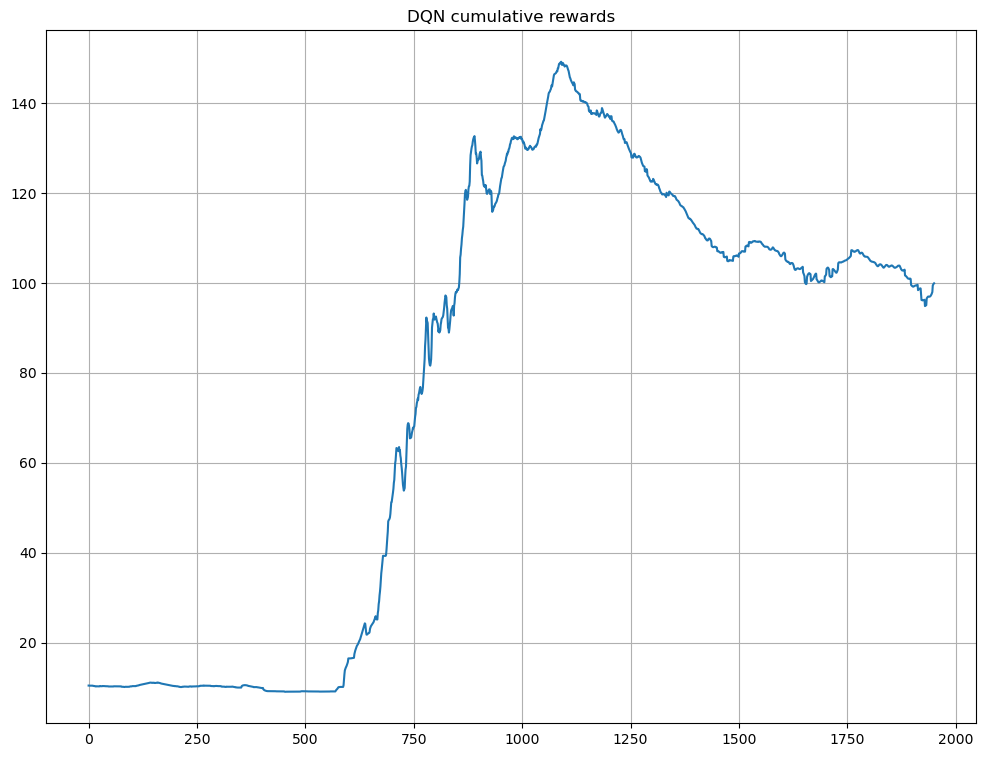

In [161]:
plt.figure(figsize=(12,9))
plt.plot(running_mean(cumulative_rewards, 50))
plt.title("DQN cumulative rewards")
plt.grid()

### Learning rate scheduling

To further stabilize the learning process, we can make our model to satisfy the Robbins-Munro sequence:

- $\sum \alpha \rightarrow \infty$
- $\sum \alpha^2 < \infty$

which essentialy means we should decrease our learning rate at some point. To do that, we can use one of the many learning rate schedulers available in `torch.optim.lr_scheduler`. I picked `MultiStepLR`, as I don't want to decrease the learning rate in the beginning. Feel free to experiment with other approaches.

In [168]:
policy_network = QNetwork(n_states=4, n_actions=2, hidden_dim=128).to(device)
policy_optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=5e-4)
# declaring the scheduler
policy_scheduler = torch.optim.lr_scheduler.MultiStepLR(policy_optimizer, milestones=[1000,1200,1400,1600,1800], gamma=0.1)
target_network = QNetwork(n_states=4, n_actions=2, hidden_dim=128).to(device)

In [169]:
NUM_TRAJECTORIES = 2000
MAX_EPISODE_LENGTH = 500

gamma = 0.99
EPSILON = 0.05
SOFT_UPDATE = 0.01
BATCH_SIZE = 512
WARMUP = 1000

cumulative_rewards_scheduler = []
policy_losses = []

transition_buffer = ReplayBuffer(10000)
for tau in tqdm(range(NUM_TRAJECTORIES)):
    
    state, info = env.reset(seed=123)

    done = False
    
    t = 0

    while done == False and t < MAX_EPISODE_LENGTH:
        action_q_values = policy_network(torch.tensor(state).to(device))

        action = np.random.choice(
            [torch.argmax(action_q_values.flatten()).detach().cpu().numpy(), 
             np.random.choice([0,1])], 
             p=[1-EPSILON, EPSILON])

        prev_state = state

        state, reward, done, truncation, info = env.step(action)

        transition_buffer.append((prev_state, action, reward, state, done))
        

        t += 1


    cumulative_rewards_scheduler.append(t)

    if len(transition_buffer) > WARMUP:
        states, actions, rewards, next_states, dones = transition_buffer.sample(sample_size=BATCH_SIZE)
        q_target = target_network(torch.tensor(next_states).to(device)).detach().max(1)[0]
        expected_values = rewards + gamma * q_target*(torch.ones(BATCH_SIZE).to(device) - dones)
        output = policy_network(states).gather(1, actions.view(-1,1))
        loss = F.mse_loss(output.flatten(), expected_values)
        policy_losses.append(loss.item())
        policy_optimizer.zero_grad()
        loss.backward()
        policy_optimizer.step()
        # policy scheduler step - in our case, if we're at one of the milestones, decrease the learning rate by factor of γ
        policy_scheduler.step()

        parameter_update(policy_network, target_network, SOFT_UPDATE)

  5%|▌         | 103/2000 [00:01<00:19, 97.22it/s]/tmp/ipykernel_30474/3279804566.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_target = target_network(torch.tensor(next_states).to(device)).detach().max(1)[0]
100%|██████████| 2000/2000 [03:43<00:00,  8.94it/s]


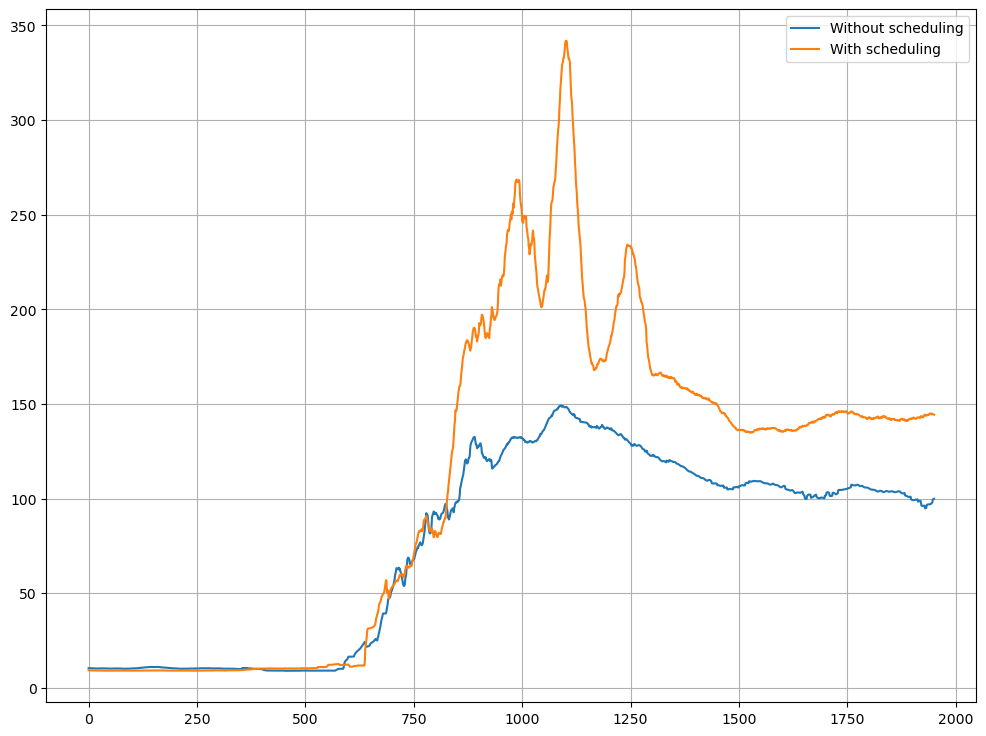

In [170]:
plt.figure(figsize=(12,9))
plt.plot(running_mean(cumulative_rewards, 50), label="Without scheduling")
plt.plot(running_mean(cumulative_rewards_scheduler, 50), label="With scheduling")
plt.grid()
plt.legend()

In [171]:
import pandas as pd

df = pd.DataFrame(cumulative_rewards_scheduler, columns=['reward'])
df.to_csv('DQN.csv')